# In-class 08 Recurrent neural network
---
## Abstract 
In this course, you need to accomplish
1. Loading a data from csv file.
2. Apply filter to the data and pick the feature you need when training a RNN model.
3. Splite a dataset into two part.
4. Build a LSTM model.
5. Evaluate the performance of your model and visualize the learning curve.
6. Plot the ROC curve and compute the AUC.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from sklearn.utils import shuffle
import time
%config InlineBackend. figure_format = 'retina'

# Import TensorFlow and scikit-learn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split


print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2000112613564040733
]
/kaggle/input/phys591000-week08/Data_LSTM_10000.csv
/kaggle/input/phys591000-week08/Data_LSTM_Large.csv


## Part 1

### Data I/O

### **In this part, you need to load the data from csv file locate in `/kaggle/input/phys591000-week08/Data_LSTM_10000.csv`.**

A jet object may contains several constituents. 

The content of dataset contains the `pt`, `eta`, `phi`, `rel_eta`, `rel_phi`, `jet_index`, `process`, and `label` of the constituents.

The colume with same `jet_index` represent this colume belongs to the specific jet(i.e. these columes is a `constituents` of a jet), and the `pt`, `eta`,and `phi` is the kinematice properties of the constituents.

The `rel_eta` and `rel_phi` represent the **relative** `eta` and `phi` between this constituent and the jet it belongs to(i.e. $\eta_{rel} = \eta_{constituent} - \eta_{jet}$  and  $\phi_{rel} = \phi_{constituent} - \phi_{jet}$).

In this dataset, we label the **quark** process as **0** and **wz** process as **1**.

For example, for jet number 0, it has 23 constituents.

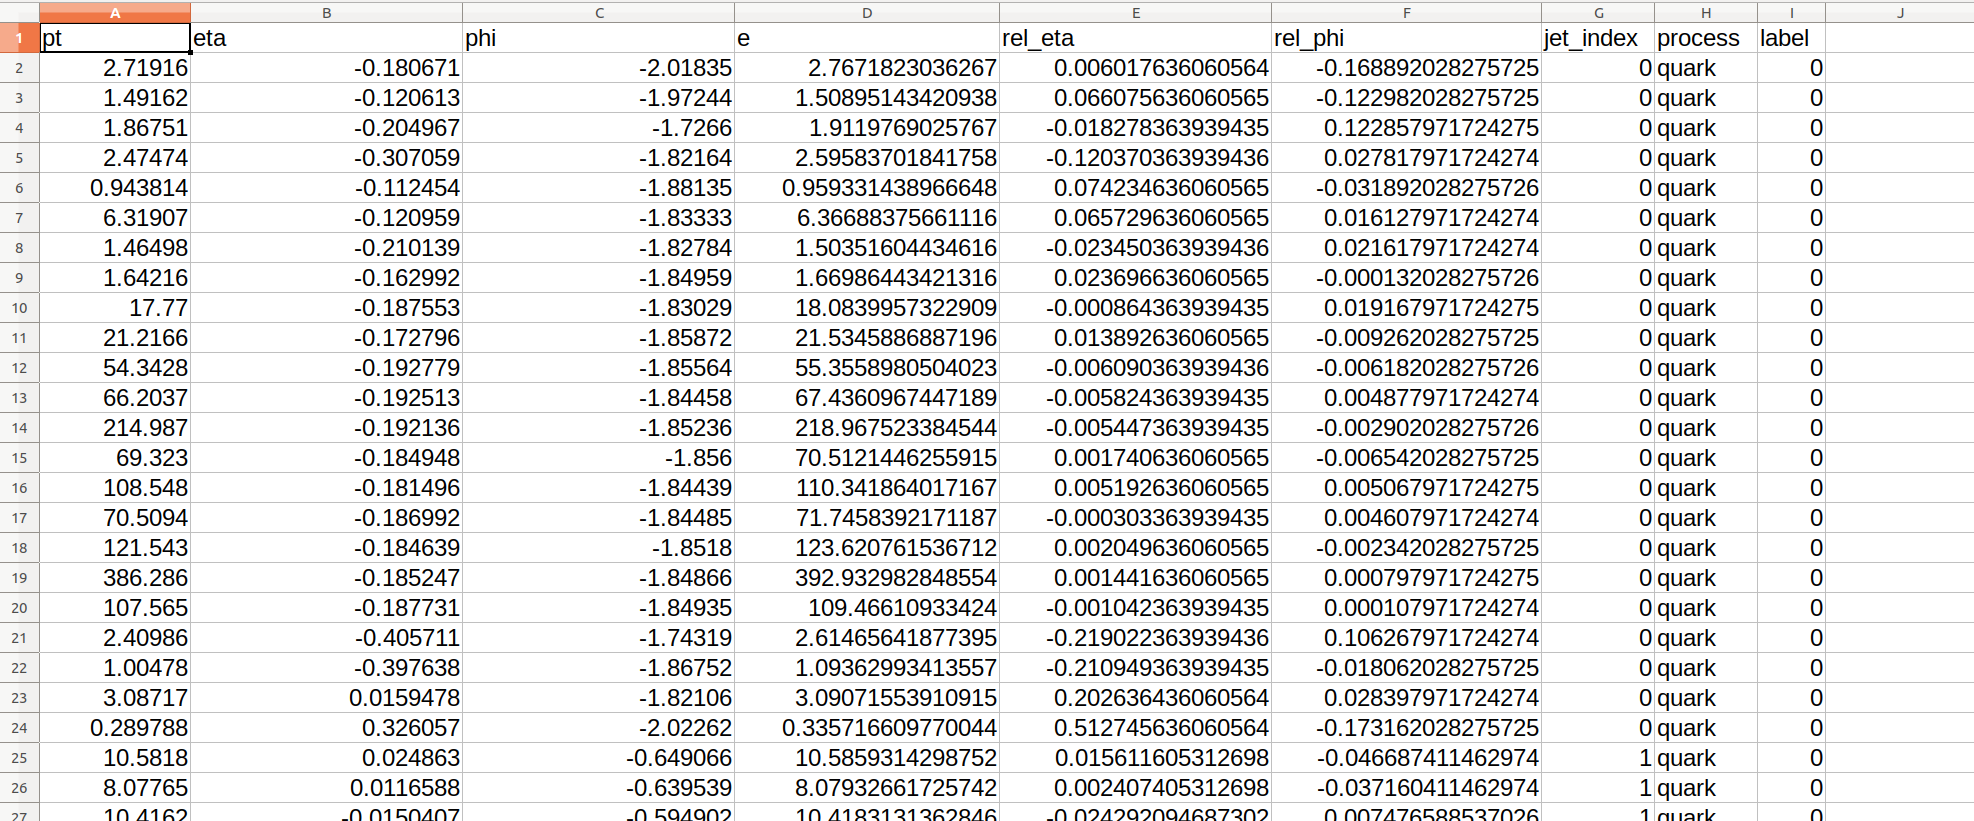


In [2]:
#################################################################################################################################
# Code for part 1
path = "/kaggle/input/phys591000-week08/"
LSTM10000 = pd.read_csv(path+"Data_LSTM_10000.csv")
#################################################################################################################################

## Part 2

Using the result you obtained in part 1, store the **top-5** constituents' `pt`,`rel_eta`,`rel_phi`,and `e` in each jet to a variable `tarin_array`.

The shape of `train_array` should be (N(selected jet), 5(five constituedescribe(four features)). (The function `numpy.zeros` may help you to accomplish this.)

After you create the `train_array`, then create another array `target_array` to store the label of the `train_array`.

The shape of `target_array` should be (N(selected jet), ).

You may feel free to use `numpy.ndarray` of `list` to finish this part.

Hint1: Your job may looks like the following operation.

Hint2: You can seperate the origin data frame to 2 dataframe w.r.t. wz/quark process, apply the operation and store the result to numpy array. Then use the `numpyp.concatenate` function to combine the array you have.

### Before  

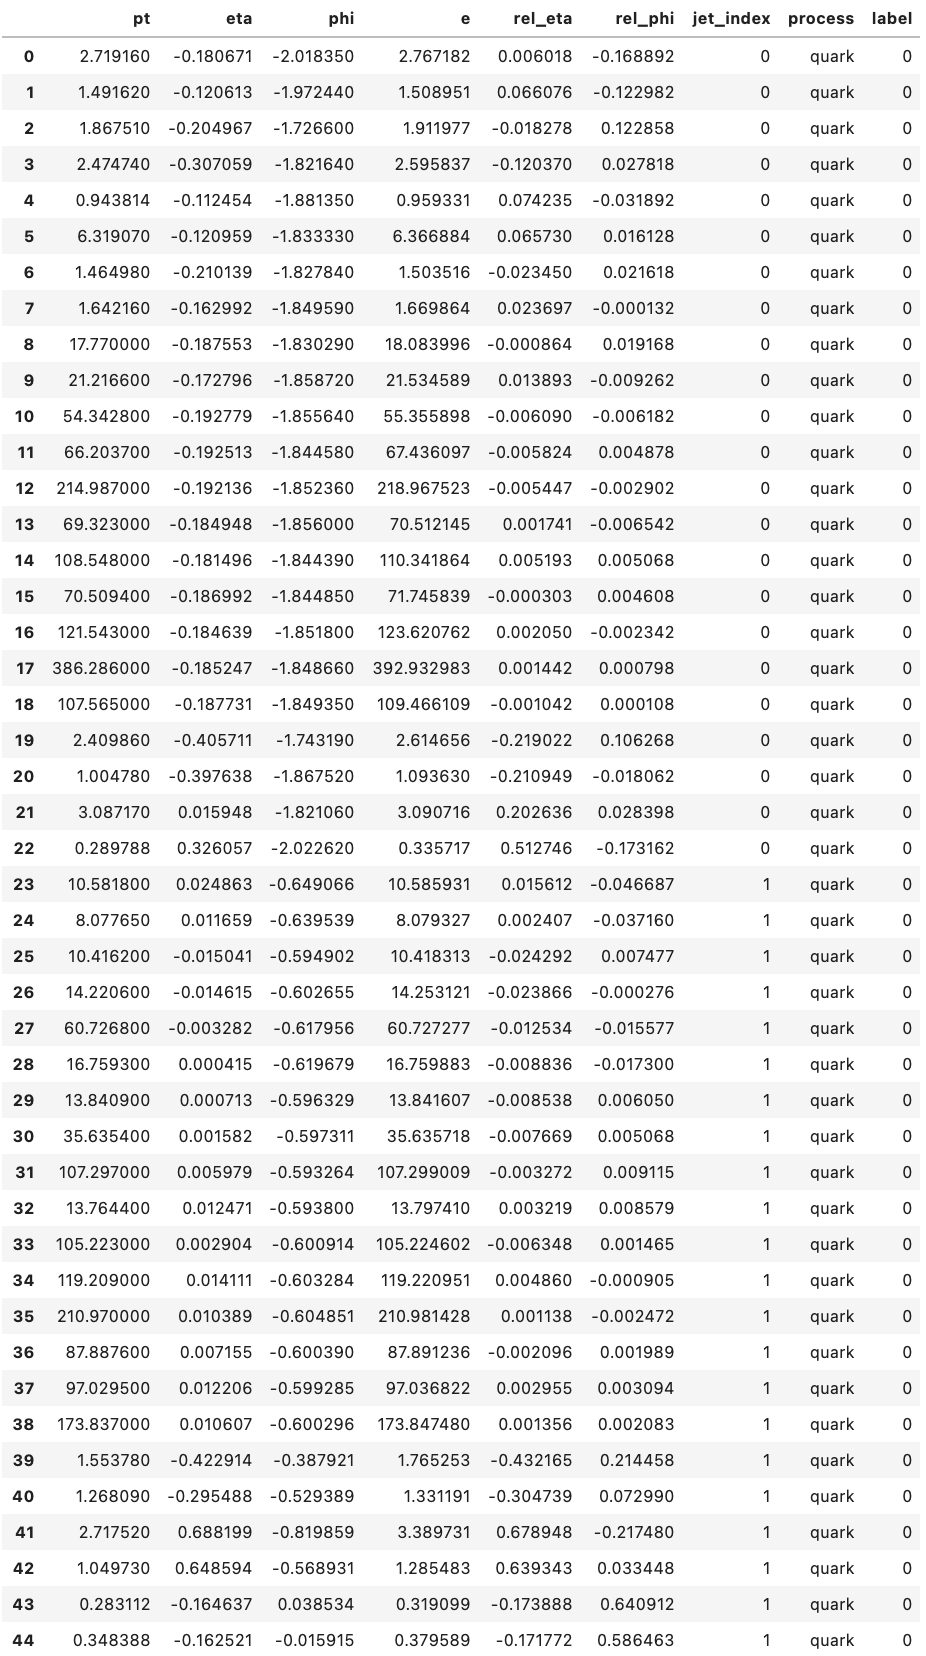

### After

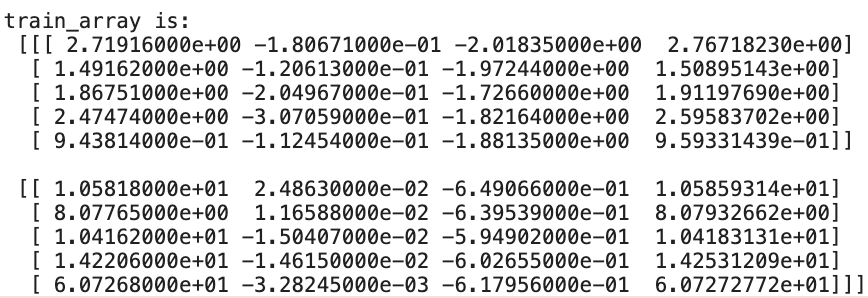

In [3]:
#################################################################################################################################
# Code for part 2
train_array = []

df = pd.DataFrame(LSTM10000)
WZ_jet = df.loc[df["label"]==1]
quark_jet = df.loc[df["label"]==0]

wz_array = []
quark_array = []
for i in range(10000):
    if len(WZ_jet[WZ_jet["jet_index"]==i]) >= 5:
        wz_tmp = WZ_jet[WZ_jet["jet_index"]==i]  
        wz_array.append(wz_tmp[["pt","eta","phi","e"]][0:5].values)
    elif len(WZ_jet[WZ_jet["jet_index"]==i]) < 5:
        wz_tmp = WZ_jet[WZ_jet["jet_index"]==i].filter(["pt","eta","phi","e"]).values
        #print(wz_tmp.shape)
        #wz_tmp = wz_tmp.filter(["pt","eta","phi","e"]).values
        #df_wz_tmp = pd.DataFrame(wz_tmp,np.zeros((5 - len(WZ_jet[WZ_jet["jet_index"]==i]),4)))
        #print(df_wz_tmp.shape)
        wz_tmp = np.concatenate((wz_tmp,np.zeros((5 - len(WZ_jet[WZ_jet["jet_index"]==i]),4))),axis=0)
        wz_array.append(wz_tmp)

        
        
for i in range(10000):
    if len(quark_jet[quark_jet["jet_index"]==i]) >= 5:
        quark_tmp = quark_jet[quark_jet["jet_index"]==i]  
        quark_array.append(quark_tmp[["pt","eta","phi","e"]][0:5].values)
    elif len(WZ_jet[WZ_jet["jet_index"]==i]) < 5:
        quark_tmp = quark_jet[quark_jet["jet_index"]==i].filter(["pt","eta","phi","e"]).values
        #print(quark_tmp.shape)
        #wz_tmp = wz_tmp.filter(["pt","eta","phi","e"]).values
        #df_wz_tmp = pd.DataFrame(wz_tmp,np.zeros((5 - len(WZ_jet[WZ_jet["jet_index"]==i]),4)))
        #print(df_wz_tmp.shape)
        quark_tmp = np.concatenate((quark_tmp,np.zeros((5 - len(WZ_jet[WZ_jet["jet_index"]==i]),4))),axis=0)
        quark_array.append(quark_tmp)
wz_array = np.array(wz_array)
quark_array = np.array(quark_array)
train_array = np.concatenate((quark_array,wz_array),axis=0)
print(wz_array.shape)
print(quark_array.shape)
print(train_array.shape)

target_array = []
for i in range(20000):
    if i < 10000:
        target_array.append(0)
    elif i >= 10000:
        target_array.append(1)
target_array = np.array(target_array)
#################################################################################################################################

(10000, 5, 4)
(10000, 5, 4)
(20000, 5, 4)


## Part 3

Using the result you obtained in part 2 and the `train_test_split` function provided by `sklearn.model_selection`.

Splite the dataset into `X_train`, `X_test`, `Y_train`,and `Y_test` by setting `test_size=0.10`. 

In [4]:
#################################################################################################################################
# Code for part 3
X_train, X_test, Y_train, Y_test = train_test_split(
    train_array, target_array, test_size=0.10, random_state=42)


#################################################################################################################################

## Part 4

Construct a sequential model using `tensorflow`.

Your model need to contains:
1. Input layer with `shape=(5,4)`.
2. One LSTM layer with `units=10` and use `relu` as activation function, make sure you set `return_sequences=True`.
3. One Dense layer with `units=1` and use `sigmoid` as activation function.

The information of `model.summary()` must be:

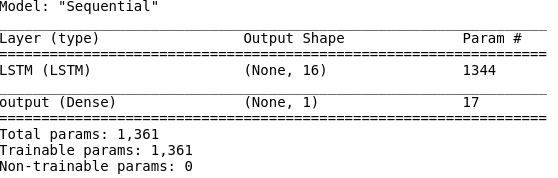

In [5]:
#################################################################################################################################
# Code for part 4
input_shape = (5,4)
model = Sequential(name = 'Sequential')
model.add(LSTM(units = 16, activation = 'relu', return_sequences = False, input_shape = input_shape, name = "LSTM"))
model.add(Dense(units = 1, activation = 'sigmoid', name = "output"))

model_opt = keras.optimizers.Adam()#delta()

model.compile(#loss="categorical_crossentropy",
                   loss = "binary_crossentropy",
                   optimizer = 'adam',
                   metrics=["accuracy","mse"])

model.summary()
#################################################################################################################################

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 16)                1344      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


## Part 5

Train the model you just build with `epoch=200`, `batch_size = 64`, `validation_split = 0.1`, and `shuffle = True`.

Using the `history` object return from `model.fit(...)` method to plot the following plots.

1. Accuracy of training and validating.
2. Loss of training and validating.

You may plot a figure like:  
(the behavior might be different)


Epoch 1/200
254/254 [==============================] - 3s 6ms/step - loss: 0.7808 - accuracy: 0.5136 - mse: 0.2637 - val_loss: 0.6897 - val_accuracy: 0.5417 - val_mse: 0.2476
Epoch 2/200
254/254 [==============================] - 1s 4ms/step - loss: 0.7051 - accuracy: 0.5228 - mse: 0.2509 - val_loss: 0.6834 - val_accuracy: 0.5489 - val_mse: 0.2453
Epoch 3/200
254/254 [==============================] - 1s 4ms/step - loss: 0.6892 - accuracy: 0.5397 - mse: 0.2479 - val_loss: 0.6841 - val_accuracy: 0.5522 - val_mse: 0.2457
Epoch 4/200
254/254 [==============================] - 1s 4ms/step - loss: 0.6865 - accuracy: 0.5333 - mse: 0.2468 - val_loss: 0.6837 - val_accuracy: 0.5606 - val_mse: 0.2452
Epoch 5/200
254/254 [==============================] - 1s 4ms/step - loss: 0.6848 - accuracy: 0.5429 - mse: 0.2461 - val_loss: 0.6829 - val_accuracy: 0.5606 - val_mse: 0.2450
Epoch 6/200
254/254 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.5500 - mse: 0.2465 - val_loss

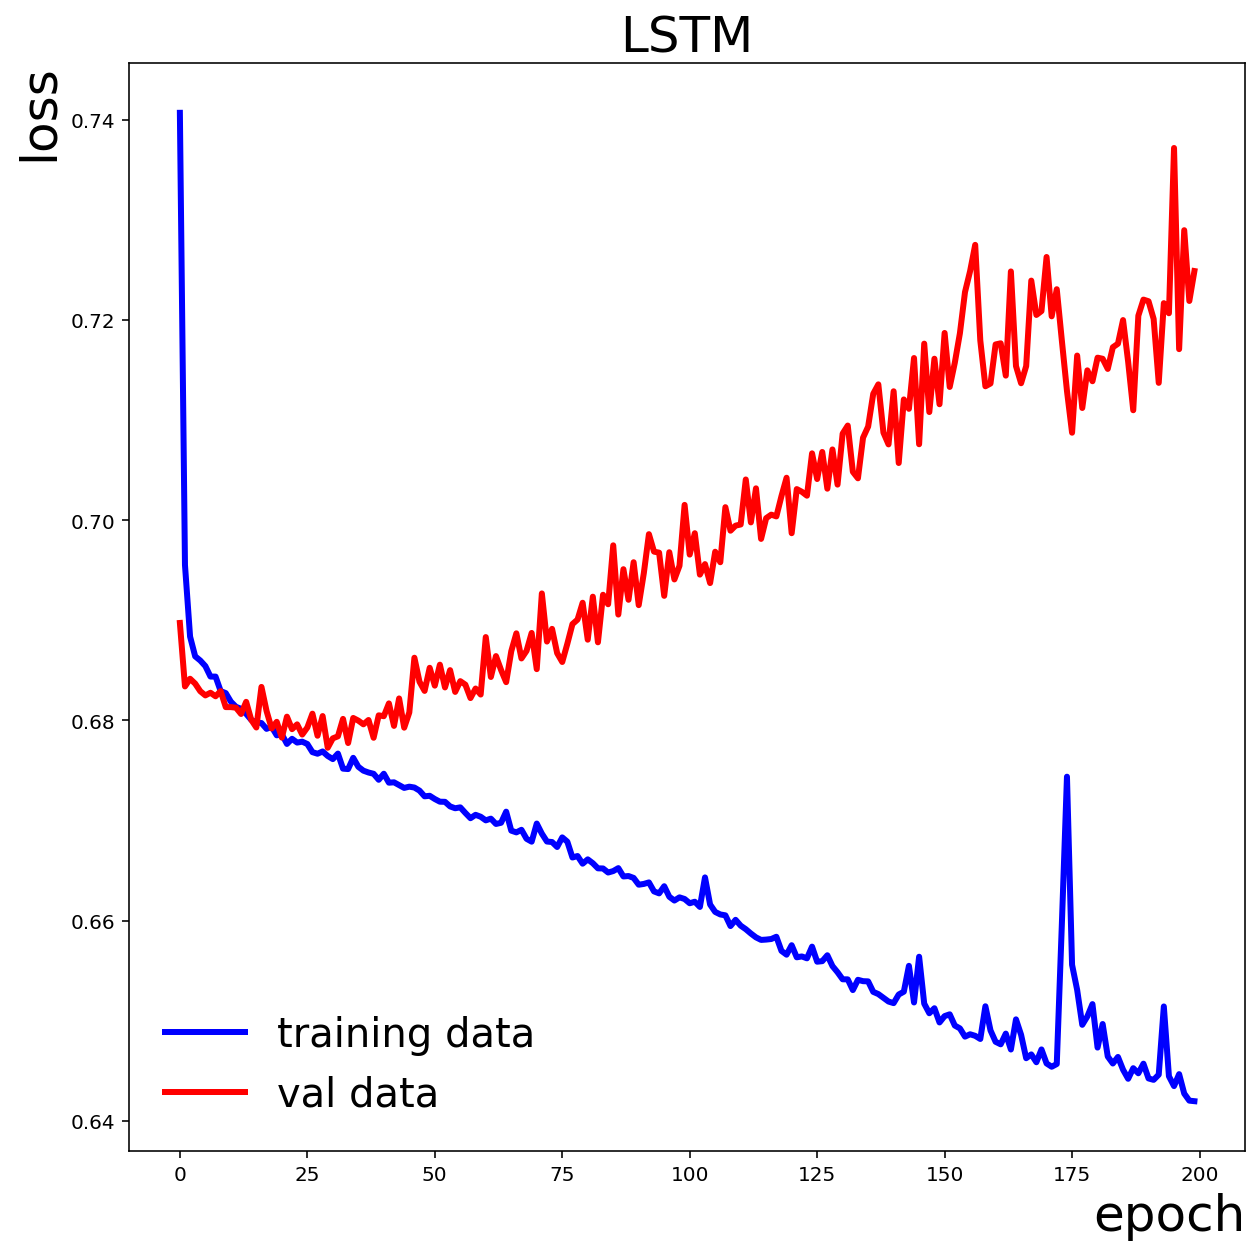

In [6]:
#################################################################################################################################
# Code for part 5
History_jet = model.fit( X_train, Y_train,
               validation_split= 0.1,
               batch_size=64,
               epochs=200,
               shuffle = True,
               verbose=1
              )


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet.history["val_loss"], label='val data',c='red',linewidth = 3)

plt.title("LSTM", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()
#################################################################################################################################

## Part 6

Using the test dataset you obtained in part 3 to plot the ROC curve and compute AUC.

Test accuracy is 55.04999756813049


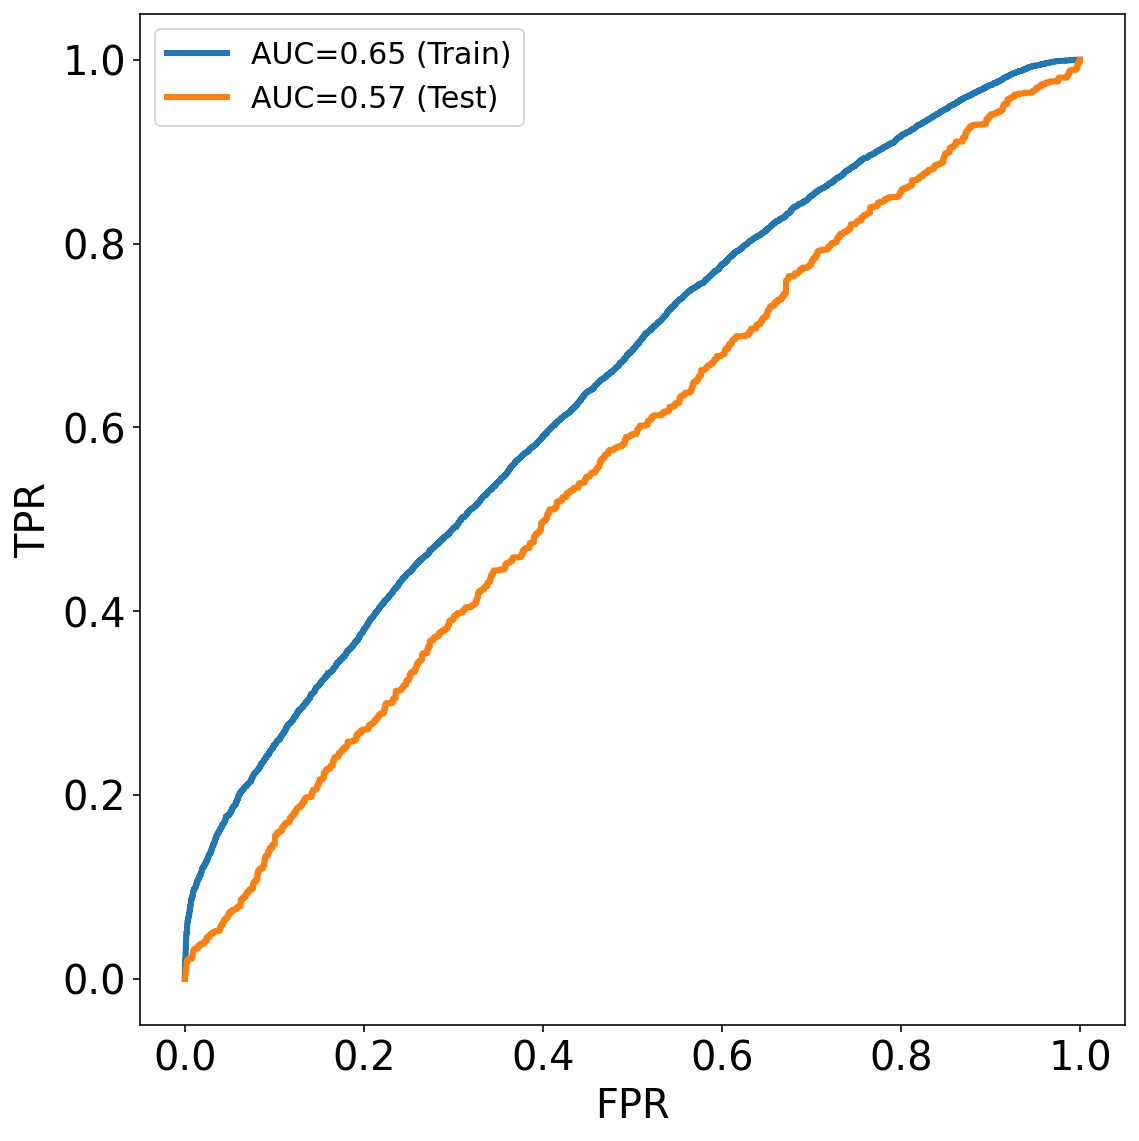

In [7]:
#################################################################################################################################
# Code for part 6
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



"""
Make Prediction for Train and Test Data Set
"""
Y_train_prediction = model.predict(X_train)
Y_test_prediction = model.predict(X_test)

"""
Evaluate the model
"""
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy is {}".format(scores[1] * 100))


"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC
"""
auc_train = metrics.roc_auc_score(Y_train[:],Y_train_prediction[:])
auc_test = metrics.roc_auc_score(Y_test[:],Y_test_prediction[:])


"""
Calculate FPR and TPR
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(Y_train[:],Y_train_prediction[:])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(Y_test[:],Y_test_prediction[:])


"""
Generate ROC figure
"""
fig, ax = plt.subplots(1,1, figsize=(8,8))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()


#################################################################################################################################